In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from datetime import date, timedelta
%matplotlib inline

today = date.today()

# LSTM Crypto Stock Predictor Using Closing Prices

In this notebook, we build and train a custom LSTM RNN that uses a 10 day window of XRP closing prices to predict the 11th day closing price. 

We will perform the following tasks:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

In [2]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

## Data Preparation

In this section, we prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

For data prep we perform the following:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: we followed the following input format for the LSTM:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [3]:
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=730)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('XRP-USD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
#print(data.head())
data.tail(10)


,Date,Open,High,Low,Close,Adj Close,Volume
721,2022-03-27,0.832815,0.857376,0.830339,0.857343,0.857343,1505124770
722,2022-03-28,0.857408,0.908086,0.855211,0.863304,0.863304,3205464277
723,2022-03-29,0.863089,0.884441,0.848861,0.858000,0.858000,2120020042
724,2022-03-30,0.857942,0.871279,0.849425,0.860814,0.860814,1832671641
725,2022-03-31,0.860880,0.870866,0.803881,0.814564,0.814564,2611691934
726,2022-04-01,0.814709,0.833678,0.810256,0.827740,0.827740,2091887103
727,2022-04-02,0.827735,0.848600,0.824828,0.824919,0.824919,1624227101
728,2022-04-03,0.824891,0.850154,0.817265,0.842950,0.842950,1348476817
729,2022-04-04,0.842923,0.842952,0.810890,0.827251,0.827251,1876069127
730,2022-04-05,0.827935,0.833054,0.823133,0.824046,0.824046,1649471616


In [4]:
# set the index
data.set_index('Date', inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-01,0.814709,0.833678,0.810256,0.827740,0.827740,2091887103
2022-04-02,0.827735,0.848600,0.824828,0.824919,0.824919,1624227101
2022-04-03,0.824891,0.850154,0.817265,0.842950,0.842950,1348476817
2022-04-04,0.842923,0.842952,0.810890,0.827251,0.827251,1876069127
2022-04-05,0.827935,0.833054,0.823133,0.824046,0.824046,1649471616


In [5]:
data_df = data.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])
data_df.head()

,Open,Close
Date,,
2020-04-05,0.181764,0.179406
2020-04-06,0.179628,0.195506
2020-04-07,0.195686,0.192093
2020-04-08,0.192137,0.200869
2020-04-09,0.200973,0.198257


In [6]:
# Trim the dataset to begin on September 01 2020, or about 18 months of data
data_df = data_df.loc["2020-09-01":, :]
data_df.tail()

,Open,Close
Date,,
2022-04-01,0.814709,0.827740
2022-04-02,0.827735,0.824919
2022-04-03,0.824891,0.842950
2022-04-04,0.842923,0.827251
2022-04-05,0.827935,0.824046


<AxesSubplot:title={'center':'Crypto Close Prices'}, xlabel='Date'>

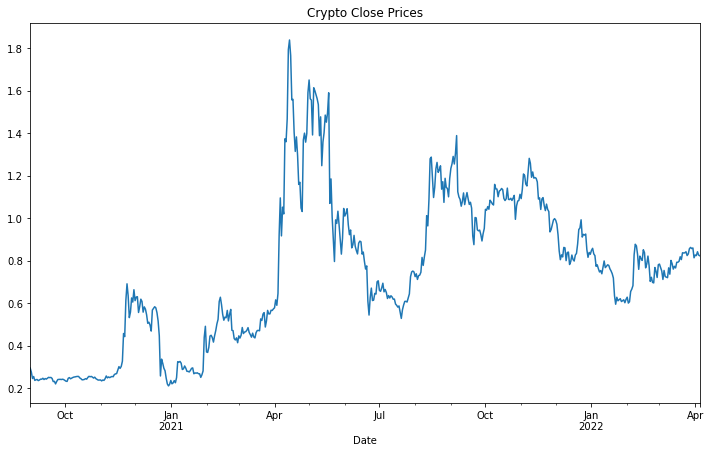

In [7]:
# Plot just the "Settle" column from the dataframe:
data_df.Close.plot(title='Crypto Close Prices', figsize=(12,7))

In [8]:
# Create a function that accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, we will experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
# It was determined a 7 day window was most optimized for loss
window_size = 7

# Column index 0 is the 'Open' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(data_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[0.29569599 0.27646101 0.24658    0.25588301 0.237692   0.240731
  0.242174  ]
 [0.27646101 0.24658    0.25588301 0.237692   0.240731   0.242174
  0.236753  ]
 [0.24658    0.25588301 0.237692   0.240731   0.242174   0.236753
  0.239609  ]
 [0.25588301 0.237692   0.240731   0.242174   0.236753   0.239609
  0.24353001]
 [0.237692   0.240731   0.242174   0.236753   0.239609   0.24353001
  0.243292  ]] 

y sample values:
[[0.236753  ]
 [0.239609  ]
 [0.24353001]
 [0.243292  ]
 [0.247814  ]]


In [10]:
# We used 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler to scale data between 0 and 1.
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:2]} \n")
print (f"X_test sample values:\n{X_test[:2]}")

X_train sample values:
[[[0.05153471]
  [0.03971531]
  [0.02135421]
  [0.02707066]
  [0.01589276]
  [0.01776015]
  [0.01864683]]

 [[0.03971531]
  [0.02135421]
  [0.02707066]
  [0.01589276]
  [0.01776015]
  [0.01864683]
  [0.01531577]]] 

X_test sample values:
[[[0.52611142]
  [0.52295614]
  [0.58258166]
  [0.56938702]
  [0.56903981]
  [0.54690094]
  [0.56320478]]

 [[0.52295614]
  [0.58258166]
  [0.56938702]
  [0.56903981]
  [0.54690094]
  [0.56320478]
  [0.56561599]]]


## Build and Train the LSTM RNN

In this section, we designed a custom LSTM RNN and fit (train) it using the training data.

We performed the following tasks:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# LSTM model code  
# Kept dropouts to help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))


In [15]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [16]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 5)              140       
_________________________________________________________________
dropout (Dropout)            (None, 7, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [17]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 401 samples
Epoch 1/10


2022-04-05 10:07:03.294096: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_7222_7691_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_8311' and '__inference___backward_standard_lstm_7222_7691' both implement 'lstm_121d1f38-8e8b-4f28-af37-2de03adb84e2' but their signatures do not match.


401/401 [==============================] - 8s 21ms/sample - loss: 0.0257
Epoch 2/10
401/401 [==============================] - 4s 10ms/sample - loss: 0.0328
Epoch 3/10
401/401 [==============================] - 4s 10ms/sample - loss: 0.0263
Epoch 4/10
401/401 [==============================] - 4s 9ms/sample - loss: 0.0192
Epoch 5/10
401/401 [==============================] - 4s 9ms/sample - loss: 0.0156
Epoch 6/10
401/401 [==============================] - 4s 9ms/sample - loss: 0.0165
Epoch 7/10
401/401 [==============================] - 4s 9ms/sample - loss: 0.0152
Epoch 8/10
401/401 [==============================] - 4s 9ms/sample - loss: 0.0141
Epoch 9/10
401/401 [==============================] - 4s 9ms/sample - loss: 0.0140
Epoch 10/10
401/401 [==============================] - 4s 9ms/sample - loss: 0.0128


## Model Performance

In this section, we evaluate the model using the test data. 

The following tasks were performed:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Code note
In order to 'inverse/revert' the scaling, we applied the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [18]:
# Evaluate the model
model.evaluate(X_test, y_test)

2022-04-05 10:08:10.969286: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_17517' and '__inference_standard_lstm_17517_specialized_for_sequential_lstm_2_StatefulPartitionedCall_at___inference_distributed_function_17847' both implement 'lstm_cfac1b53-cc78-43aa-98ab-c4a89102b805' but their signatures do not match.


173/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.006283935380162876

In [ ]:
# Predictions
predicted = model.predict(X_test)

In [20]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
# Create a DataFrame of Real and Predicted values
crypto = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data.index[-len(real_prices): ]) 
crypto.tail()

,Real,Predicted
Date,,
2022-04-01,0.814564,0.956116
2022-04-02,0.827740,0.956808
2022-04-03,0.824919,0.957908
2022-04-04,0.842950,0.957178
2022-04-05,0.827251,0.954208


<AxesSubplot:title={'center':'Closing Prices'}, xlabel='Date'>

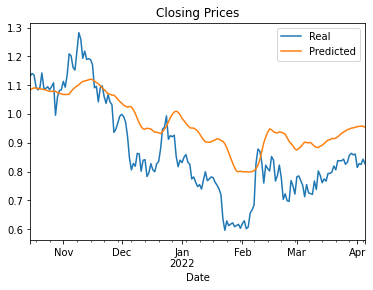

In [23]:
# Plot the real vs predicted values as a line chart
crypto.plot(title='Closing Prices')